In [2]:
import os

# os.environ['KMP_DUPLICATE_LIB_OK']='True' # only potentially necessary if you have MacBook with M1/M2 chip

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import copy
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
# download MNIST data

# download training set
mnist_training = torchvision.datasets.MNIST('./', train=True, download=True, transform=transforms.ToTensor())
# download test set
mnist_testing = torchvision.datasets.MNIST('./', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:02<00:00, 3986834.54it/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3044072.13it/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4684172.31it/s]


Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



In [4]:
# download MNIST data

# download training set
mnist_training = torchvision.datasets.MNIST('./', train=True, download=True, transform=transforms.ToTensor())
# download test set
mnist_testing = torchvision.datasets.MNIST('./', train=False, download=True, transform=transforms.ToTensor())

In [ ]:
# download MNIST data

# download training set
mnist_training = torchvision.datasets.MNIST('./', train=True, download=True, transform=transforms.ToTensor())
# download test set
mnist_testing = torchvision.datasets.MNIST('./', train=False, download=True, transform=transforms.ToTensor())

In [5]:
# model code
class CNN(nn.Module):
    # constructor
    def __init__(self, channel_widths, pooling, nonlinearity=nn.ReLU()):
        super(CNN, self).__init__()
        layers = []
        for i in range(len(channel_widths)-2):
            # convolution layer
            # you can play around with kernel_size, padding, and stride if you like
            # kernel_size is most likely to have an impact
            # arguments are: Conv2d(n_input_channels, n_output_channels, 
            #                       filter_side_length, padding, stride_length)
            layers.append(nn.Conv2d(channel_widths[i], channel_widths[i+1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
            layers.append(nonlinearity) # non-linearity
        # add final layer
        layers.append(nn.Conv2d(channel_widths[-2], channel_widths[-1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
        self.backbone = nn.Sequential(*layers)
        self.global_pooling = pooling # reduce each of the H x W feature maps to a single pooled value
        self.pool_size = pooling.output_size[0]*pooling.output_size[1]
        self.linear = nn.Linear(channel_widths[-1]*self.pool_size, 10)  # score each class to obtain logits
    # forward pass
    def forward(self, x):
        B = x.size(0) # number of input images
        features = self.backbone(x) # get feature maps (B, N_feature_maps, H, W)
        pooled_features = self.global_pooling(features) # (B, N_feature_maps, 1, 1)
        pooled_features = pooled_features.view(B, -1) # (B, N_feature_maps)
        logits = self.linear(pooled_features) # (B, N_classes)
        return logits

In [6]:
def train(model, training_data, training_indices, validation_indices, config, verbose=False):
    # unpack configuration parameters
    lr = config['lr'] # learning rate
    n_epochs = config['n_epochs'] # number of passes (epochs) through the training data
    batch_size = config['batch_size']
    
    # set up optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # set up dataloaders
    train_sampler = torch.utils.data.SubsetRandomSampler(training_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(validation_indices)
    trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, sampler=val_sampler)
    
    # training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0
    best_model = None
    for n in range(n_epochs):
        # set model to training mode (unnecessary for this model, but good practice)
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for images, targets in trainloader:
            optimizer.zero_grad() # zero out gradients
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            loss.backward() # backpropagate to compute gradients
            optimizer.step() # update parameters using stochastic gradient descent
            # update epoch statistics
            epoch_loss += loss.item() # batch loss
            epoch_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item() # number of correct predictions
            
        # validation
        epoch_loss /= len(trainloader)
        epoch_acc /= len(training_indices)
        val_loss, val_acc = validate(model, valloader, criterion)
        val_loss /= len(valloader)
        val_acc /= len(validation_indices)
        
        # log epoch information
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # save best model, if necessary
        if val_acc > best_val_accuracy:
            best_model = copy.deepcopy(model)
        if verbose and (n+1) % (int(n_epochs/20)) == 0:
            print('Epoch {}/{}: (Train) Loss = {:.4e}, Acc = {:.4f}, (Val) Loss = {:.4e}, Acc = {:.4f}'.format(
                   n+1,
                   n_epochs,
                   epoch_loss,
                   epoch_acc,
                   val_loss,
                   val_acc))
        
        
    return (np.array(train_losses),
            np.array(train_accuracies),
            np.array(val_losses),
            np.array(val_accuracies),
            best_model)
        
def validate(model, dataloader, criterion):
    val_loss = 0
    val_acc = 0
    # set model to eval mode (again, unnecessary here but good practice)
    model.eval()
    # don't compute gradients since we are not updating the model, saves a lot of computation
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            val_loss += loss.item()
            val_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return val_loss, val_acc

def test(model, dataset):
    # test best model on withheld test data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            test_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return test_acc/len(dataset)

In [7]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 1000 # 100 examples per class
N_validation_examples = 1000 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(mnist_training)),
                               size=N_training_examples+N_validation_examples)
training_indices = all_indices[:N_training_examples]
validation_indices = all_indices[N_training_examples:]

# configuration parameters, you can play around with these
config = {'lr': 3e-1,
          'n_epochs': 200,
          'batch_size': 100}
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 16, 16] # must start with a 1 and be at least length--2
model = CNN(channel_widths, pool_fcn)

# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model,
                                                                   mnist_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 10/200: (Train) Loss = 1.8778e+00, Acc = 0.3950, (Val) Loss = 1.7571e+00, Acc = 0.4240
Epoch 20/200: (Train) Loss = 7.3377e-01, Acc = 0.7590, (Val) Loss = 9.0962e-01, Acc = 0.7320
Epoch 30/200: (Train) Loss = 2.6664e-01, Acc = 0.9200, (Val) Loss = 3.5887e-01, Acc = 0.8970
Epoch 40/200: (Train) Loss = 2.1565e-01, Acc = 0.9320, (Val) Loss = 3.1556e-01, Acc = 0.9120
Epoch 50/200: (Train) Loss = 9.8435e-02, Acc = 0.9760, (Val) Loss = 3.0490e-01, Acc = 0.9060
Epoch 60/200: (Train) Loss = 3.9571e-02, Acc = 0.9970, (Val) Loss = 3.3276e-01, Acc = 0.9180
Epoch 70/200: (Train) Loss = 2.4361e-02, Acc = 0.9990, (Val) Loss = 3.3802e-01, Acc = 0.9130
Epoch 80/200: (Train) Loss = 1.6196e-02, Acc = 0.9990, (Val) Loss = 3.4299e-01, Acc = 0.9180
Epoch 90/200: (Train) Loss = 1.0791e-02, Acc = 0.9990, (Val) Loss = 3.5744e-01, Acc = 0.9160
Epoch 100/200: (Train) Loss = 7.9930e-03, Acc = 1.0000, (Val) Loss = 3.6860e-01, Acc = 0.9170
Epoch 110/200: (Train) Loss = 6.2520e-03, Acc = 1.0000, (Val) Loss = 

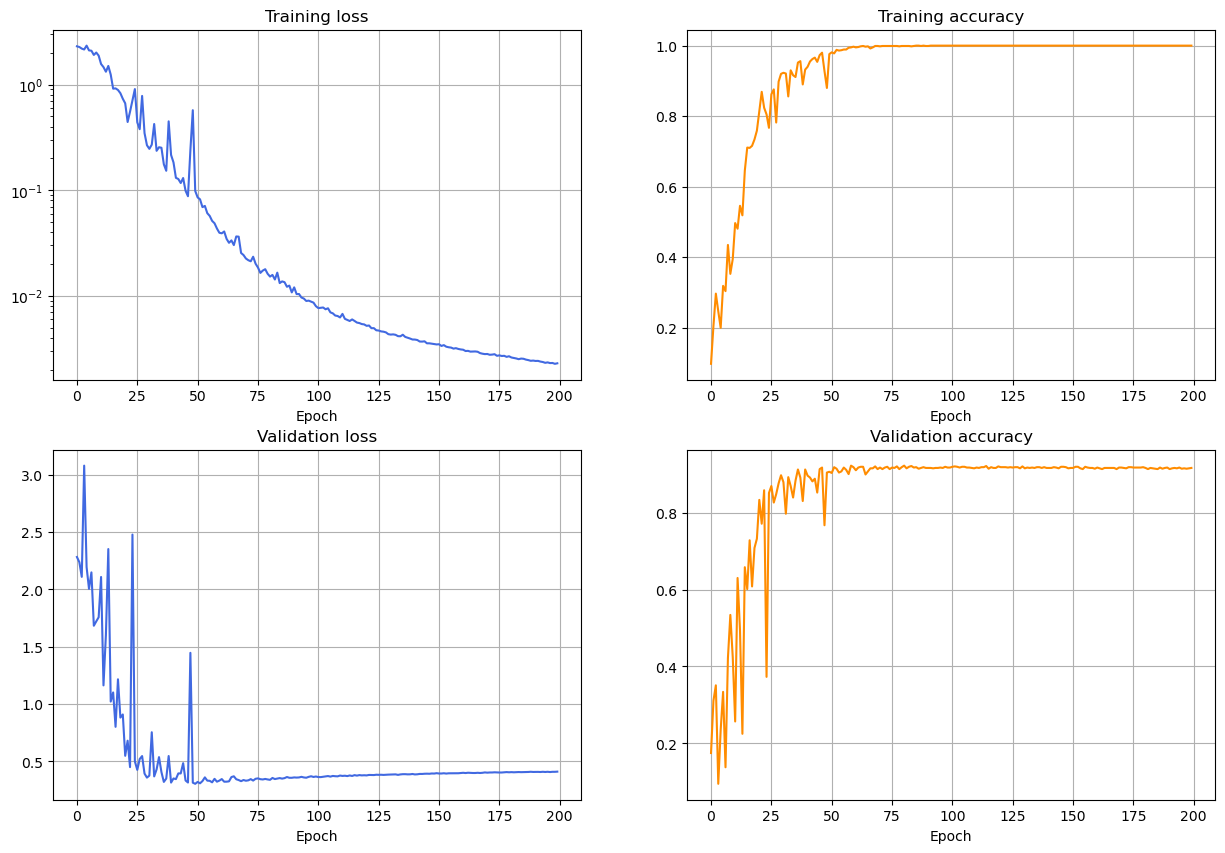

In [8]:
# plot training/validation loss and accuracy over training time
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.semilogy(train_losses, color='royalblue')
plt.xlabel('Epoch')
plt.title('Training loss')
plt.grid(True)
plt.subplot(222)
plt.plot(train_accs, color='darkorange')
plt.xlabel('Epoch')
plt.title('Training accuracy')
plt.grid(True)
plt.subplot(223)
plt.plot(val_losses, color='royalblue')
plt.xlabel('Epoch')
plt.title('Validation loss')
plt.grid(True)
plt.subplot(224)
plt.plot(val_accs, color='darkorange')
plt.xlabel('Epoch')
plt.title('Validation accuracy')
plt.grid(True)